For exploration, we should spread the choices as much as possible. Since we do not want to waste the engergy for searching the same region which may give bad results. The UCB algorithm balance the exploration and exploitation by balancing weights on predicted mean and predicted variance. To check whether UCB algorithm gives a reasonable coverage of the unknown spacing and known spacing, we run a clustering algorithm on the whole exploration space. We expect to cover several sequences in each clustering at the first a few rounds, then focusing more on sequences on the clustering gives a relatively high performance. 


## Pipeline

- Embedding
    - kmers ([3], [2,3,4,5,6])
    - onehot
- PCA
    - number of component (select by singular_values_)
- Clustering (Kmeans++)
    - number of clustering (Elbow method to select good number of clusterings)
- TSNE (to 2 dims) for visualisation
   
## Evaluation

- We show the average value and variance of label for the sequences in each clustering

Ideas:

A possible idea is to combine the clustering and successive rejects, where rejects happens in terms of clusters rather than single data points. This solves the problem that the searching space (number of arms) are too large. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.cluster import KMeans
from nltk.metrics import distance 
# import Pycluster as PC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import math

from codes.kernels_for_GPK import Phi, Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel
from codes.embedding import Embedding

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
combo6_to_idx = {}
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for i, combo in enumerate(itertools.product(char_sets, repeat= design_len)):
    combos_6.append(''.join(combo))
    combo6_to_idx[''.join(combo)] = i
    combo = pre_design + ''.join(combo) + pos_design
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

todesign6_seqs = np.asarray(combos_6) # 6-base
todesign6_data = np.asarray(list(zip(combos_6, labels))) # 6-base

shown_text = todesign6_seqs

In [3]:
todesign6_seqs

array(['AAAAAA', 'AAAAAG', 'AAAAAC', ..., 'TTTTTG', 'TTTTTC', 'TTTTTT'],
      dtype='<U6')

## Known seq

In [4]:
import pandas as pd 

Path = '../../../data/firstRound_4h.csv'

df = pd.read_csv(Path)
known_seq = np.asarray(df[['RBS6', 'AVERAGE']].drop_duplicates('RBS6'))

In [5]:
df.head()

,Unnamed: 0,RBS,Name,Rep1,Rep2,Rep3,AVERAGE,STD,PERC,Group,RBS6
0,0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,3.194925,2.783529,1.798618,2.592357,0.717515,0.246643,reference,AGGAGA
1,21,TTTAAGACGGAGATATACAT,RBS_1by1_22,0.636342,0.785468,0.153062,0.524957,0.330589,0.117560,bps_core,CGGAGA
2,22,TTTAAGAGGGAGATATACAT,RBS_1by1_23,-0.616473,-0.502488,0.414480,-0.234827,0.565197,0.043805,bps_core,GGGAGA
3,23,TTTAAGATGGAGATATACAT,RBS_1by1_24,1.249077,0.811791,-0.085595,0.658424,0.680425,0.228128,bps_core,TGGAGA
4,24,TTTAAGAACGAGATATACAT,RBS_1by1_25,1.280146,1.046771,0.953997,1.093638,0.168050,0.193737,bps_core,ACGAGA


In [6]:
known_seq.shape

(109, 2)

In [7]:
shown_text = list(shown_text)

In [8]:
known_seq_idx = []

for i in known_seq:
    idx = combo6_to_idx[i[0]]
    known_seq_idx.append(idx)
    shown_text[idx] = str(i)
    
known_seq_idx = np.asarray(known_seq_idx)

In [9]:
known_seq_idx

array([ 324, 2372, 1348, 3396,  580,   68,  836,  388,  260,  452,  356,
        340,  372,  328,  320,  332,  326,  325,  327, 2002, 3245, 1049,
       1846, 3631, 1050,  784, 3794, 3100, 1216, 1504, 2362,  530, 1996,
       1288, 2704,  222, 2506,  669, 1314,  936, 1124,  822, 2083, 1736,
       1042, 2983, 3884, 2322, 1028, 2389, 3349,   87, 2929, 2888, 2525,
       1109, 2836,  981, 3252,  281,  343, 2109, 3734,   29, 2385, 3089,
       3093, 3195,  113, 2598, 1805, 2292, 2383, 2964,  660,  916, 2643,
       2352,  546, 3276, 3003,  819, 3549, 3822, 2184, 2820,  772, 3091,
       3844, 1284, 1356, 1337, 1332, 1336, 2724, 4093, 4092, 2047, 3071,
       2729, 2728, 4094, 1706, 1023,  682, 3754, 1328, 2730, 4095])

### Second round UCB recommendations

In [10]:
Path = '../../../data/bandit_recs_second_round.csv'

df = pd.read_csv(Path)
ucb_rec = list(df['bandit'].drop_duplicates())

In [11]:
ucb_rec_idx = []

for i in ucb_rec:
    if len(i) == 20:
        string = i[7:13]
        idx = combo6_to_idx[string]
        ucb_rec_idx.append(idx)
     
ucb_rec_idx = np.asarray(ucb_rec_idx)

In [12]:
ucb_rec_idx

array([1867, 2011, 1883, 1947, 1915, 2004, 2027, 2006,  587, 3035, 1955,
       2331, 1547, 1922, 1858, 1874, 1899,  331, 1938, 1755,  635, 2000,
       1787, 1771, 2038, 3028, 3025, 1739, 2523, 2022, 1903, 1862,  603,
       3190, 1958, 2315, 2043, 1875, 1891,  155, 1967, 1860, 2003, 2034,
       1611, 1995, 2008, 3051, 1931, 1963, 1179, 2019, 1872, 3163, 3147,
       3355, 3014, 1778, 1859, 1974, 1243, 3403, 1227, 1971, 1983, 1781,
       3030, 1942, 3019, 1763, 2539, 1936, 1499, 1980, 1951, 1222, 1748,
       2171, 3062, 1939, 2843, 1223, 1147,  731, 1659, 2427, 1887, 2459,
       1910, 2335])

## Setting

In [13]:
random_state = 0
n_dim = 2 # dimension reduction 
scores = {}

In [14]:
def show_tsne_with_clustering(tsne_X, n_clusters, y_km):
    plt.figure(figsize = (15,15))
    for i in range(n_clusters):
        plt.scatter(
            tsne_X[y_km == i, 0], tsne_X[y_km == i, 1],
            s=50, 
            label=str(i)
            )
    plt.legend()
    plt.show()

# Comparision for Kmers embedding

In [15]:
l_list = [3]

#kernel = Spectrum_Kernel(l_list = l_list, weight_flag = False, padding_flag = False, gap_flag = False)
#X_spec, Y_spec = kernel.distance(todesign6_seqs)

wd_kernel = WeightedDegree_Kernel(l_list = [6])
distance = wd_kernel.distance(todesign6_seqs)

#X_spec_pca = PCA(n_components= 15).fit_transform(X_spec)


In [16]:
tsne = TSNE(n_components = n_dim, metric = 'precomputed')
tsne_X_spec = tsne.fit_transform(distance)

### Select number of clusterings for Kmeans

In [29]:
n_clusters = 15
file_name = 'tsne_kmeans++_wd_6_' +  str(n_clusters) + '_clusters_kmedoids_20bases'
print(file_name)

# choose X_spec or tsne_X_spec
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=n_clusters, metric = 'precomputed', init='k-medoids++', random_state=random_state).fit(distance)
y_km_spec = kmedoids.labels_

# show_tsne_with_clustering(tsne_X_spec, n_clusters, y_km_spec)
np.savez(file_name, coord = tsne_X_spec, text = shown_text, ykm = y_km_spec, known_seq = known_seq_idx, ucb_rec = ucb_rec_idx)
print('result saved')

tsne_kmeans++_wd_6_15_clusters_kmedoids_20bases
result saved


## Evaluation 

### Known sequence performance on clustering

In [18]:
from collections import defaultdict

idxes = np.asarray(range(len(y_km_spec)))
known_seq_clustering = defaultdict(list)
label = defaultdict(list)
mean = {}
std = {}
known_seq_clustering_count = []
clustering_count = []

for i in range(len(set(y_km_spec))):
    clustering_count.append(len(idxes[y_km_spec == i]))
    for k in idxes[y_km_spec==i]:
        if k in known_seq_idx:
            known_seq_clustering[i].append(shown_text[k])
            label[i].append(float(shown_text[k].split(' ')[-1].split(']')[0]))
    known_seq_clustering_count.append(len(label[i]))
    if len(label[i]) > 0:
        mean[i] = np.mean(label[i])
        std[i] = np.std(label[i])
# print(np.asarray(shown_text)[y_km_spec == i])

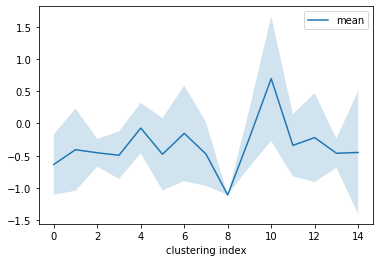

In [19]:
plt.plot(list(mean.keys()), list(mean.values()), label = 'mean')
plt.fill_between(list(mean.keys()), np.asarray(list(mean.values())) + np.asarray(list(std.values())), 
                np.asarray(list(mean.values())) - np.asarray(list(std.values())), alpha = 0.2)
plt.xlabel('clustering index')
plt.legend()

In [20]:
key_vec = []
label_vec = []
for key, value in label.items():
    if len(value) > 0:
        key_vec.append(key)
        label_vec.append(value)

Text(0.5, 1.0, 'Violin plot for labels in clustering')

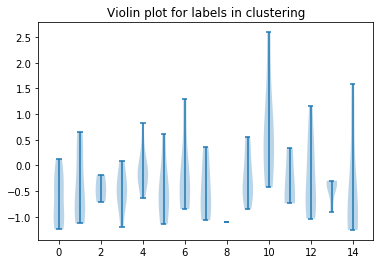

In [21]:
plt.violinplot(label_vec, key_vec)
plt.title('Violin plot for labels in clustering')

Text(0.5, 0, 'clustering index')

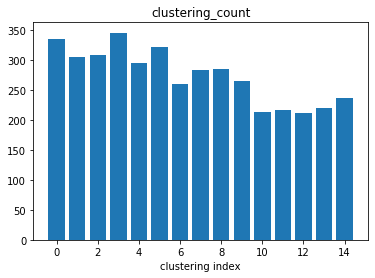

In [22]:
plt.bar(list(range(15)), clustering_count)
plt.title('clustering_count')
plt.xlabel('clustering index')

Text(0.5, 0, 'clustering index')

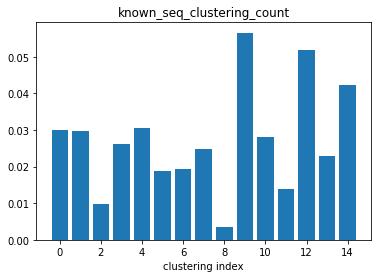

In [23]:
plt.bar(list(range(15)), np.asarray(known_seq_clustering_count)/np.asarray(clustering_count))
plt.title('known_seq_clustering_count')
plt.xlabel('clustering index')

### UCB design converage

In [24]:
idxes = np.asarray(range(len(y_km_spec)))
ucb_rec_clustering = defaultdict(list)
ucb_rec_clustering_count = []

for i in range(len(set(y_km_spec))):
    for k in idxes[y_km_spec==i]:
        if k in ucb_rec_idx:
            ucb_rec_clustering[i].append(shown_text[k])
    ucb_rec_clustering_count.append(len(ucb_rec_clustering[i]))

Text(0.5, 0, 'clustering index')

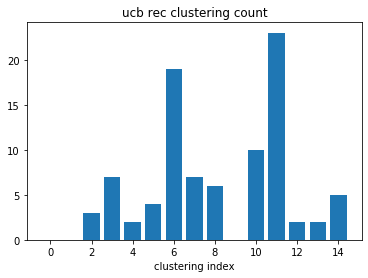

In [25]:
plt.bar(list(ucb_rec_clustering.keys()), ucb_rec_clustering_count)
plt.title('ucb rec clustering count')
plt.xlabel('clustering index')